In [1]:
# import torch
# from PIL import Image
# import open_clip

# model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
# model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
# tokenizer = open_clip.get_tokenizer('ViT-B-32')

# image = preprocess(Image.open("docs/C爱爱6LIP.png")).unsqueeze(0)
# text = tokenizer(["a diagram", "a dog", "a cat"])

# with torch.no_grad(), torch.autocast("cuda"):
#     image_features = model.encode_image(image)
#     text_features = model.encode_text(text)
#     image_features /= image_features.norm(dim=-1, keepdim=True)
#     text_features /= text_features.norm(dim=-1, keepdim=True)

#     text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

In [5]:
import open_clip
open_clip.list_pretrained()

C:\Users\dc22948\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [6]:
import numpy as np
import pandas as pd

In [7]:
# pretrained also accepts local paths
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k') 

In [8]:
model.eval()
#token 数
context_length = model.context_length
#clip可以识别的唯一单词或符号的数量。
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Context length: 77
Vocab size: 49408


In [9]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x00000224A2219990>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [10]:
from open_clip import tokenizer

In [11]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
     "motorcycle_right": "a red motorcycle standing in a garage",
    "grass": "A lush ground cover composed of small blades, commonly found in fields and lawns.",
    "coins": "A collection of metallic currency pieces.",
    "color": "A color wheel made up of various colors",
     "page": "a page of text about segmentation",
    "retina": "a layer of cells lining the back wall inside the eye",
    "coffee": "a cup of coffee on a saucer",
     "horse": "a black-and-white silhouette of a horse"
}

In [12]:
print(dir(skimage.data))

['astronaut', 'binary_blobs', 'brain', 'brick', 'camera', 'cat', 'cell', 'cells3d', 'checkerboard', 'chelsea', 'clock', 'coffee', 'coins', 'colorwheel', 'data_dir', 'download_all', 'eagle', 'file_hash', 'grass', 'gravel', 'horse', 'hubble_deep_field', 'human_mitosis', 'immunohistochemistry', 'kidney', 'lbp_frontal_face_cascade_filename', 'lfw_subset', 'lily', 'logo', 'microaneurysms', 'moon', 'nickel_solidification', 'page', 'palisades_of_vogt', 'protein_transport', 'retina', 'rocket', 'shepp_logan_phantom', 'skin', 'stereo_motorcycle', 'text', 'vortex']


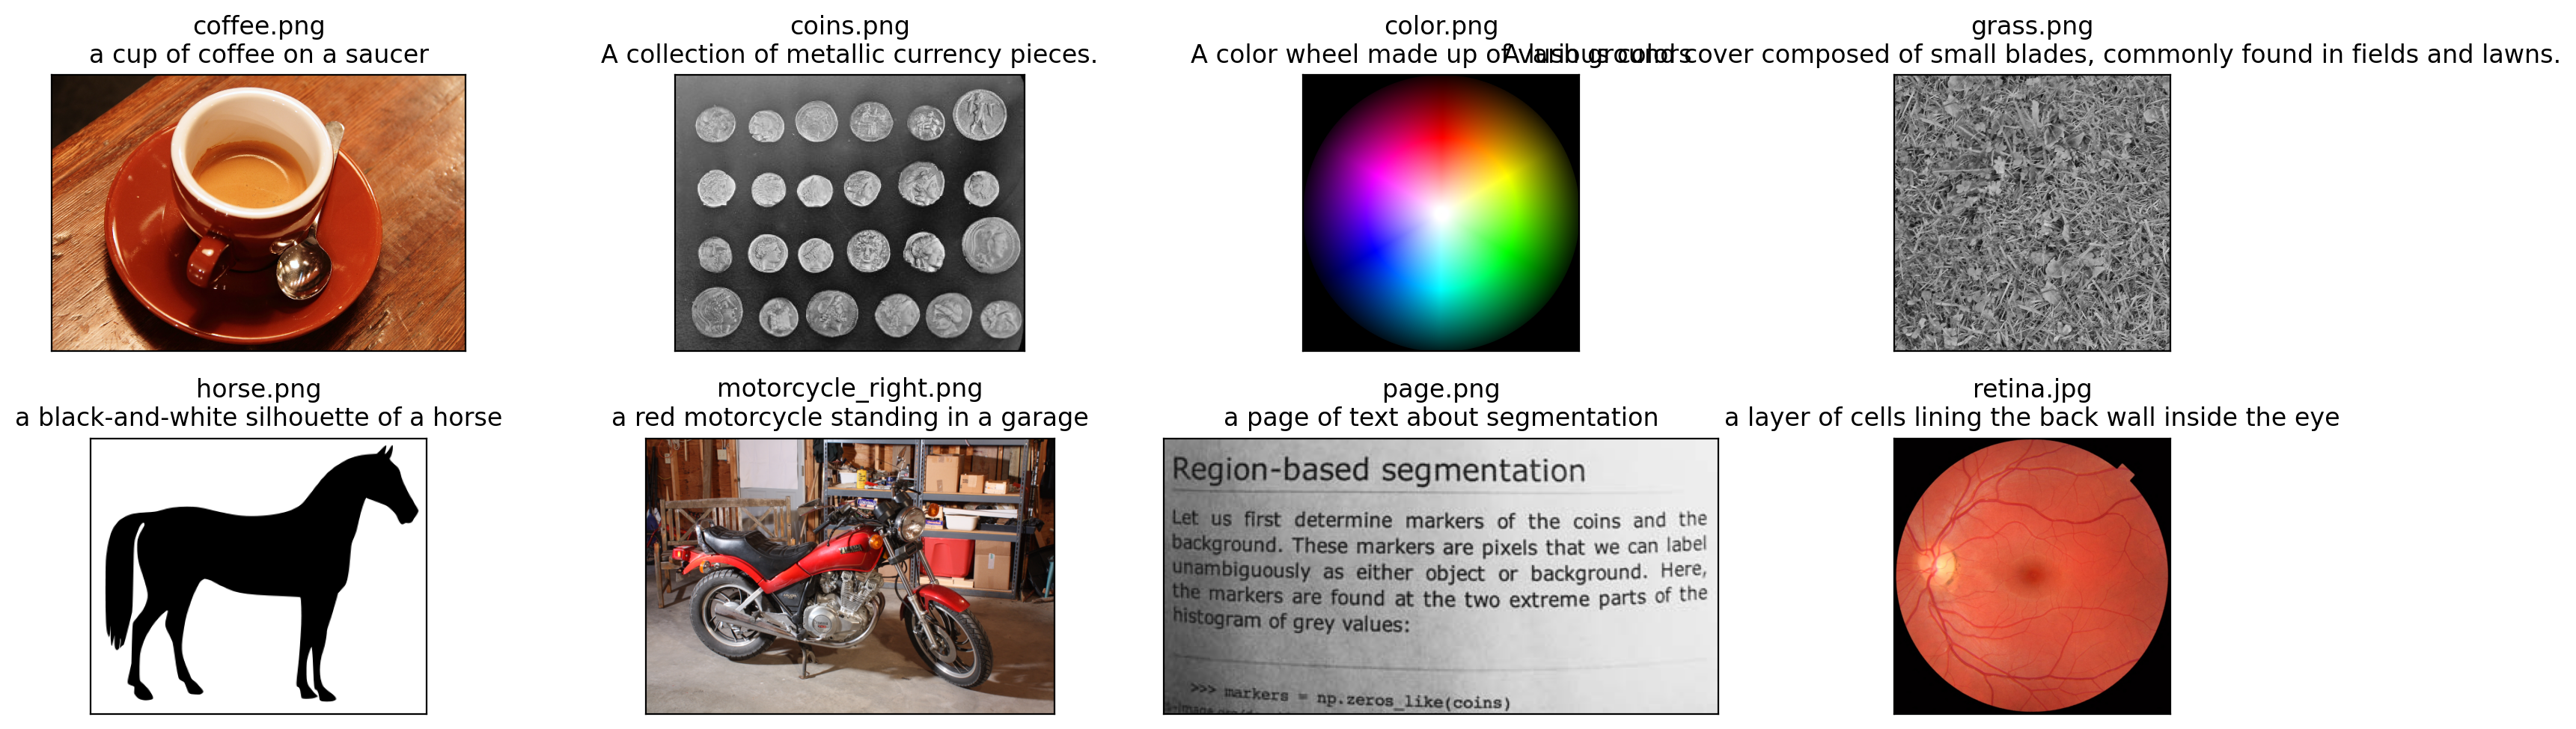

In [13]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [14]:
image_input = torch.tensor(np.stack(images))
text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])

In [15]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [16]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

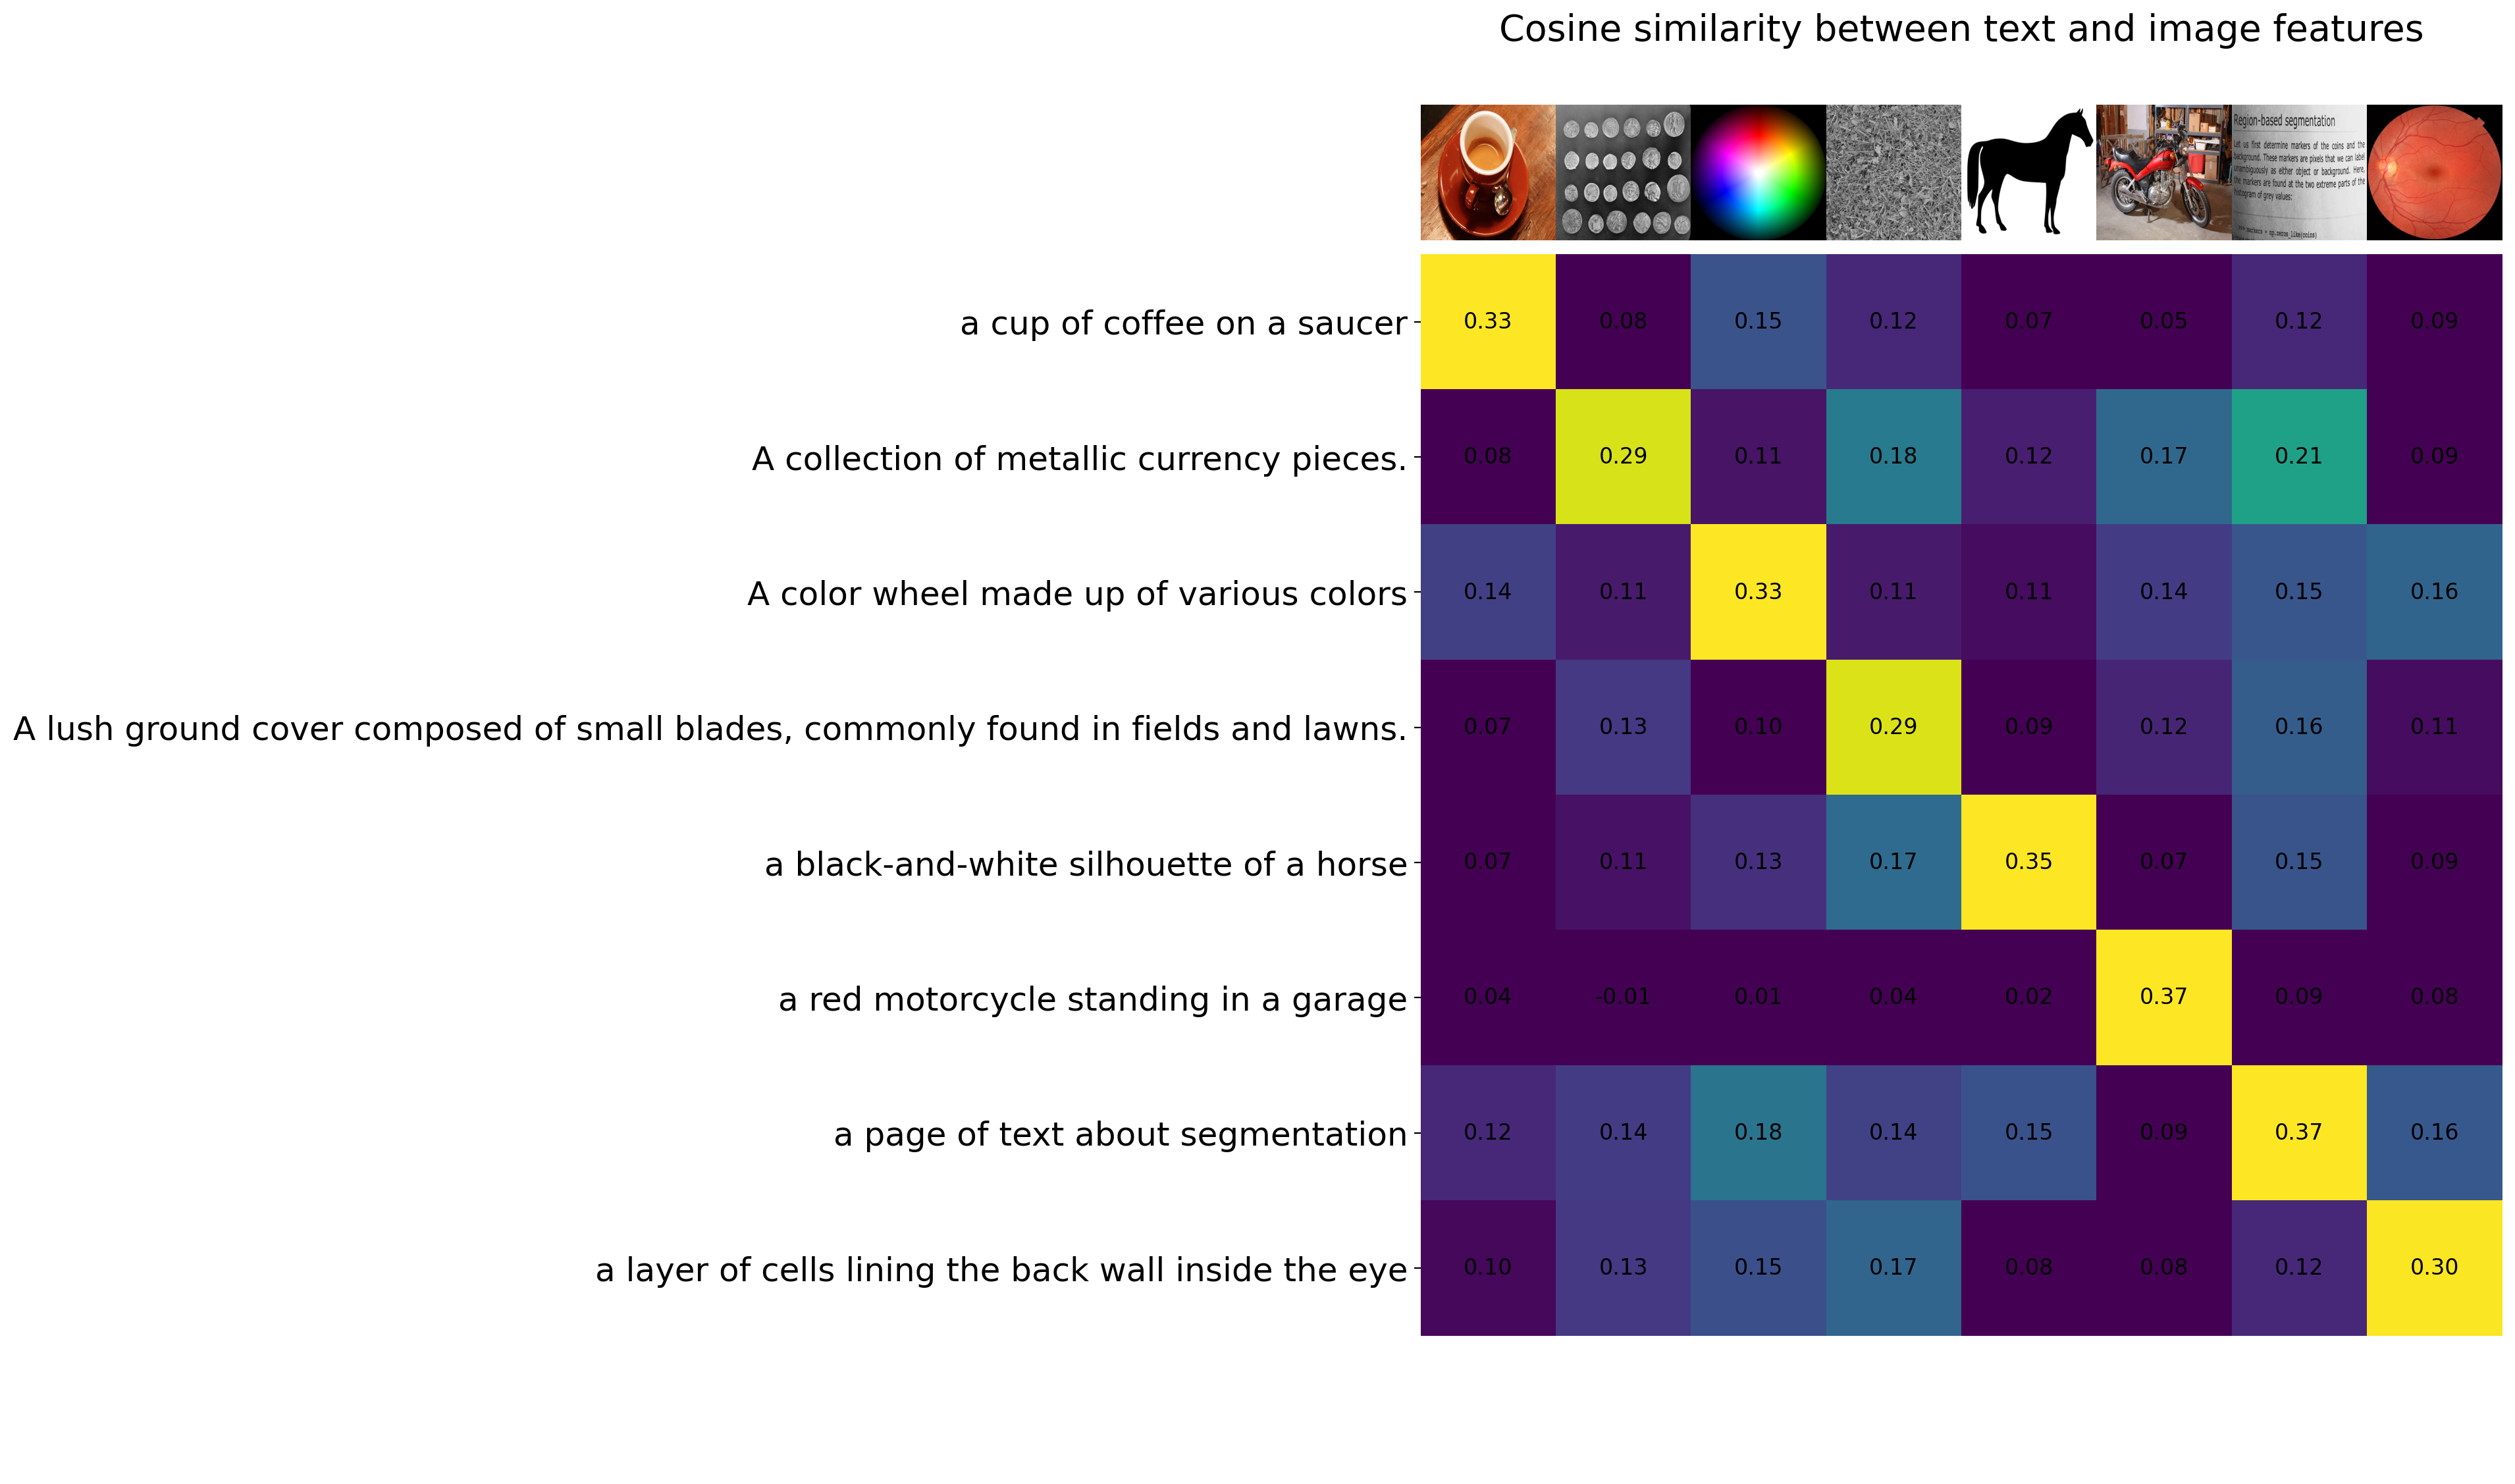

In [17]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [18]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

In [19]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x00000224A2219990>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [20]:
text_descriptions = [f"A photo of a {label}" for label in cifar100.classes]
text_tokens = tokenizer.tokenize(text_descriptions)

In [21]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

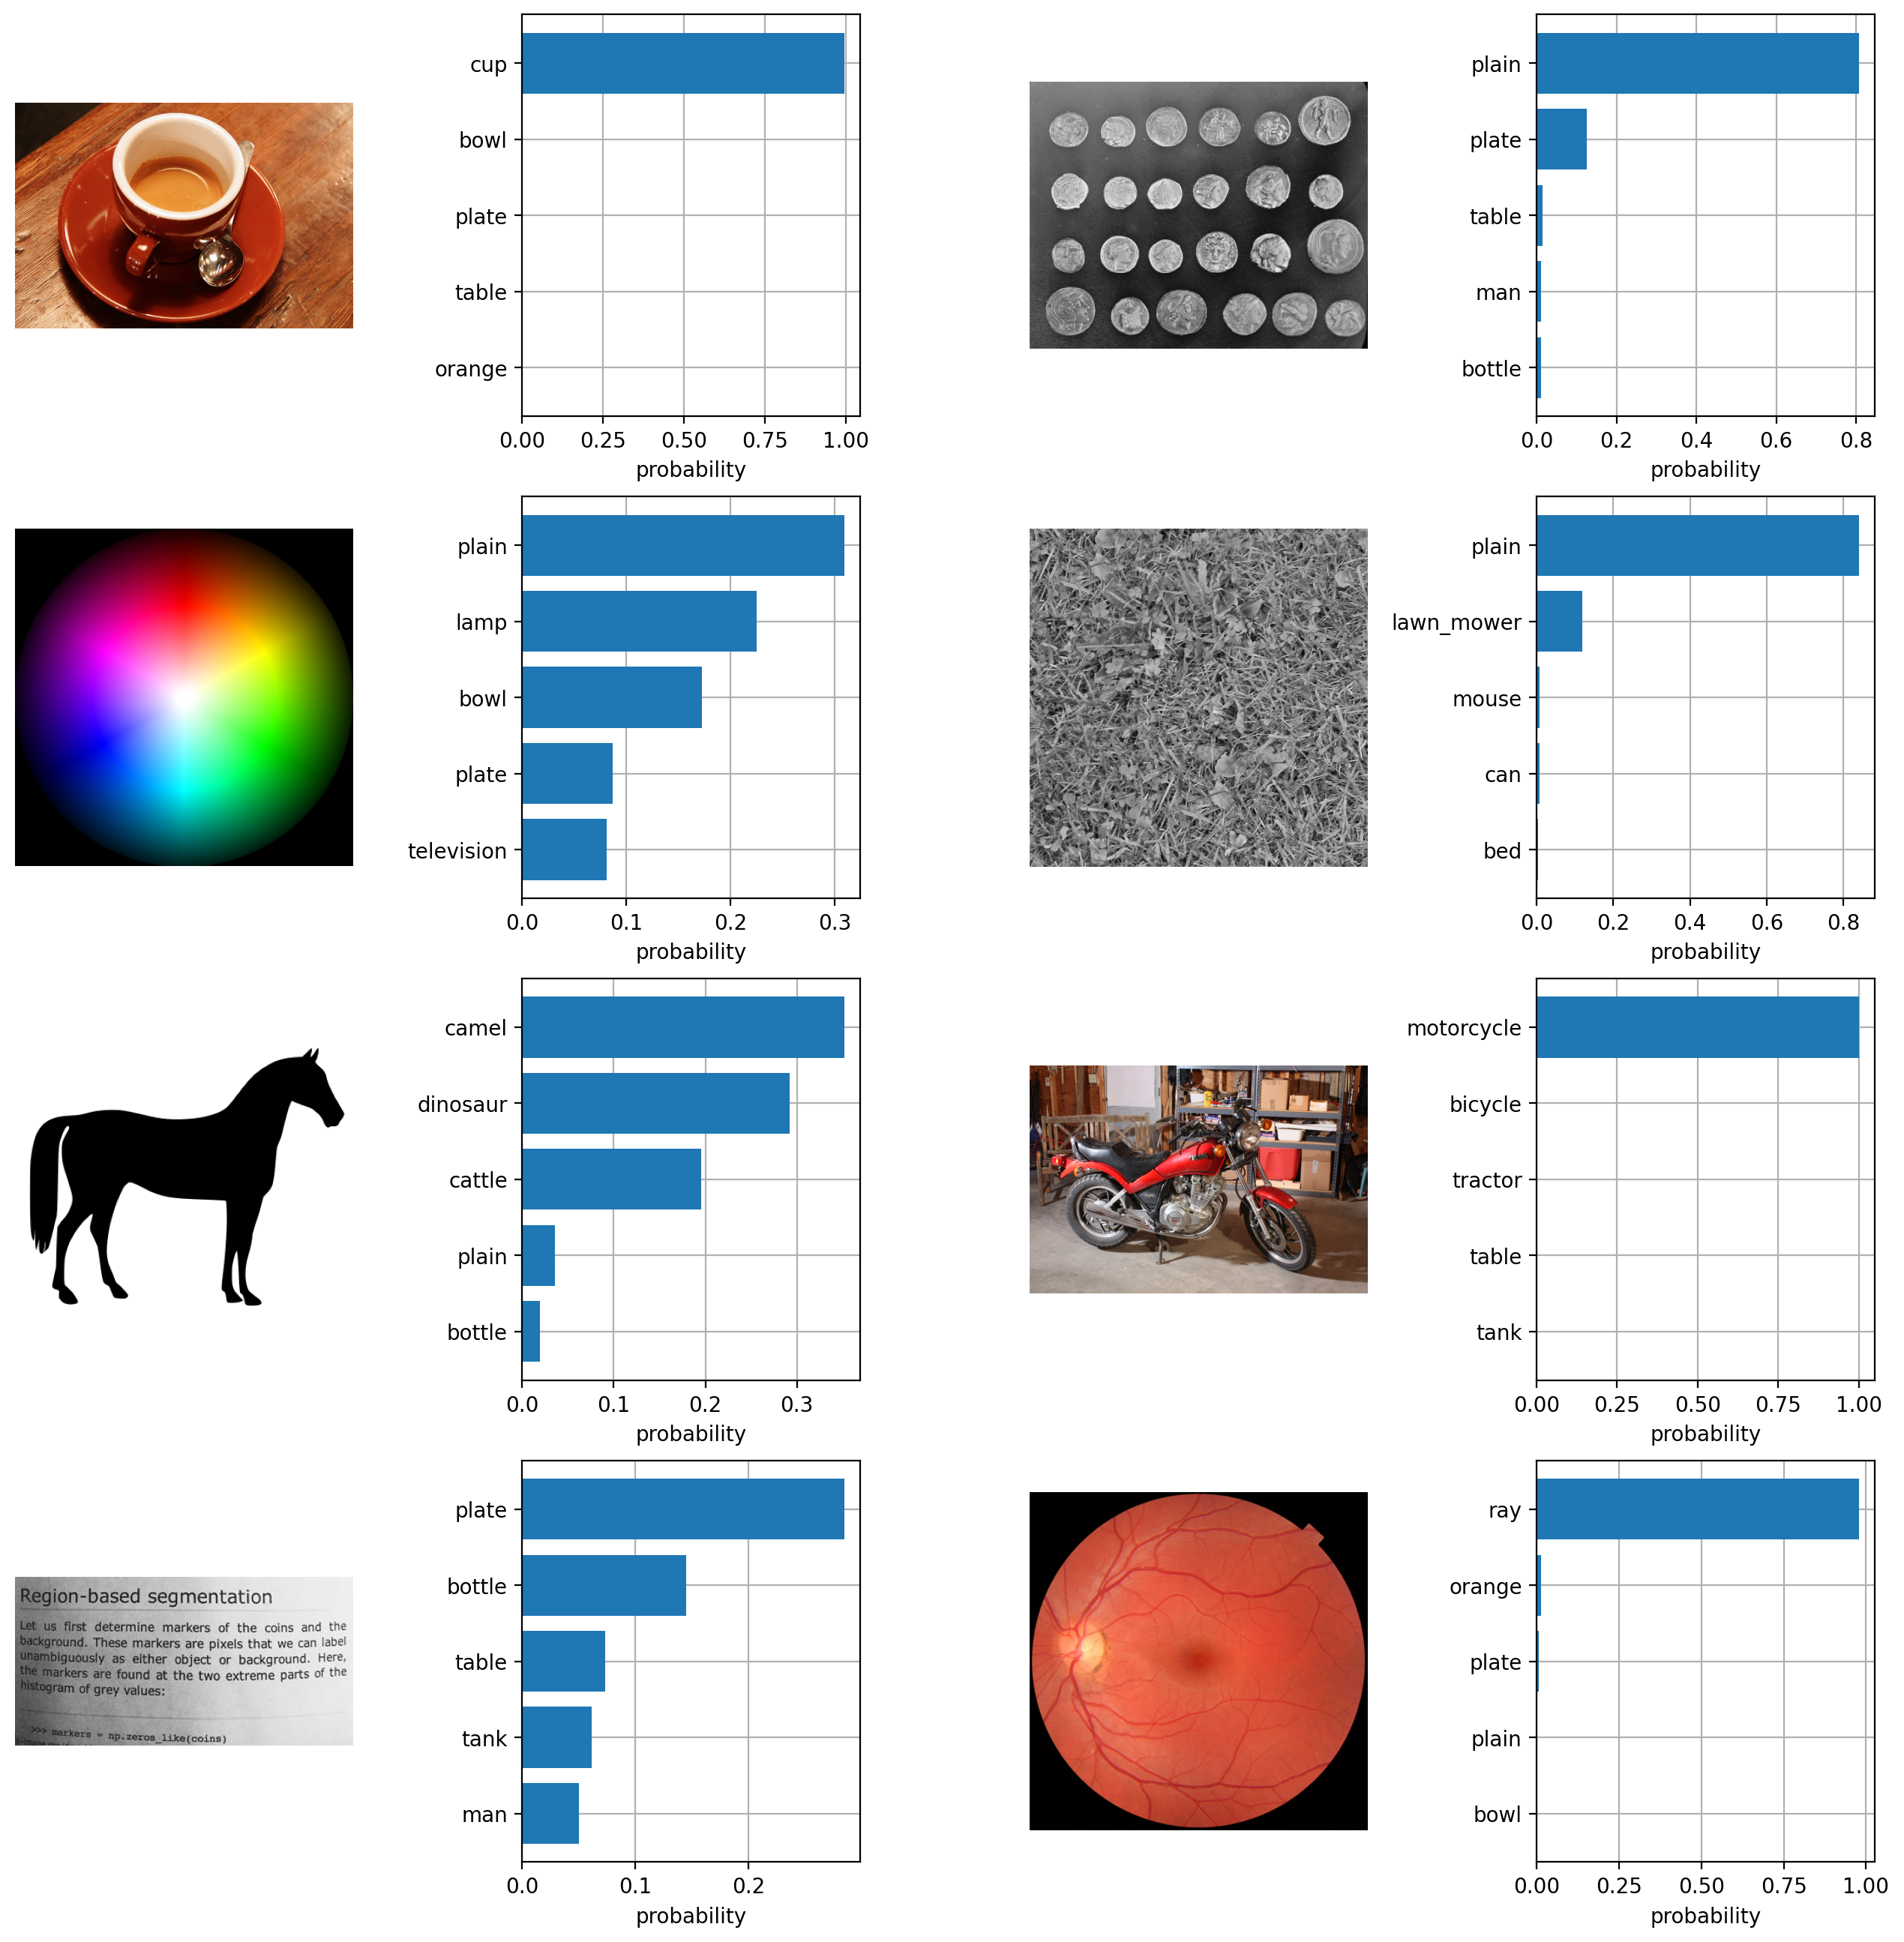

In [22]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [23]:
image_input = torch.tensor(np.stack(images))
text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

# Calibration

In [25]:
# Calibration methods including Temperature Scaling

import numpy as np
from scipy.optimize import minimize 
from sklearn.metrics import log_loss
import pandas as pd
import time
from sklearn.metrics import log_loss, brier_score_loss
from tensorflow.keras.losses import categorical_crossentropy
from os.path import join
import sklearn.metrics as metrics

## load data

In [26]:
#将CIFAR1000数据集分成train和test
cifar100_train_dataset = CIFAR100(root='./cifar10_data', train=True, download=True, transform=None)
cifar100_test_dataset = CIFAR100(root='./cifar10_data', train=False, download=True, transform=None)
cifar100_train_data = cifar100_train_dataset.data
cifar100_test_data = cifar100_test_dataset.data
cifar100_train_labels = np.array(cifar100_train_dataset.targets)
cifar100_test_labels = np.array(cifar100_test_dataset.targets)
cifar100_train_data.shape, cifar100_test_data.shape, cifar100_train_labels.shape, cifar100_test_labels.shape

100%|██████████| 169M/169M [00:29<00:00, 5.79MB/s] 


((50000, 32, 32, 3), (10000, 32, 32, 3), (50000,), (10000,))

(32, 32, 3) <class 'numpy.ndarray'>
(32, 32, 3) <class 'PIL.Image.Image'>


C:\Users\dc22948\AppData\Local\Temp\ipykernel_9936\2447753774.py:4: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  im = Image.fromarray(img, mode="RGB")


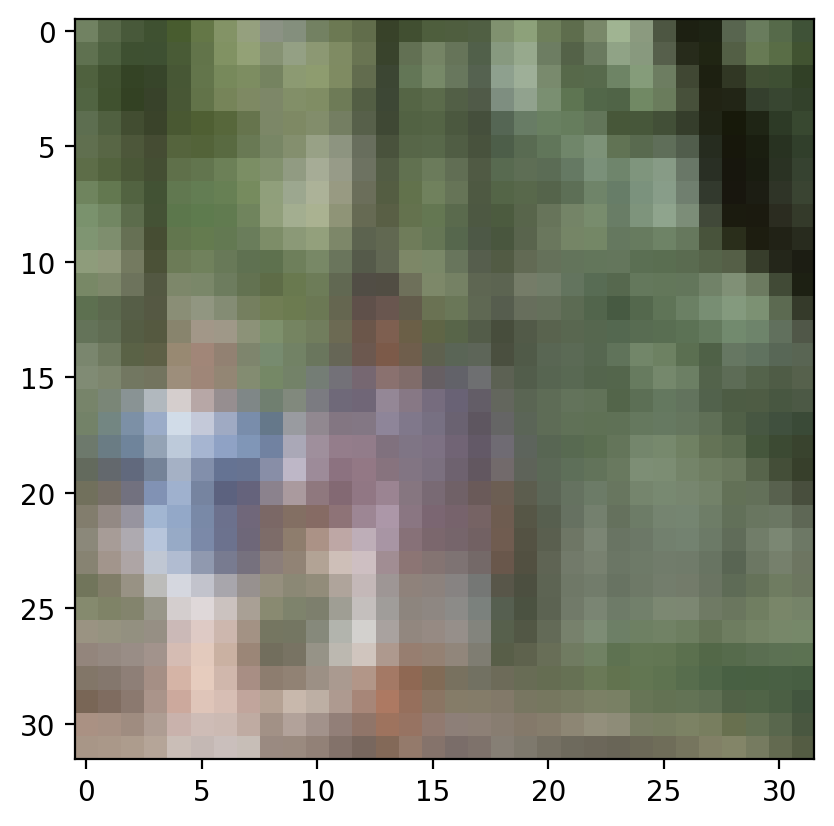

In [27]:
img = cifar100_test_data[1]
print(img.shape, type(img))
plt.imshow(img)
im = Image.fromarray(img, mode="RGB")
print(img.shape, type(im))
im_prep = preprocess(im).unsqueeze(0)
im_prep.shape
with torch.no_grad():
    image_features = model.encode_image(im_prep)


In [28]:

import torch
import numpy as np
import pickle
import os
from os.path import join
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset

In [28]:
# # 文件名: extract_logits_from_preprocessed_cifar100_small.py




# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = model.to(device).eval()


# # ============ 包装 Dataset，确保图像转为 Tensor ============
# class TensorizedDataset(Dataset):
#     def __init__(self, base_dataset):
#         self.base_dataset = base_dataset
#         self.to_tensor = transforms.ToTensor()


#     def __getitem__(self, index):
#         img, label = self.base_dataset[index]
#         if isinstance(img, np.ndarray):
#             img = Image.fromarray(img)
#         if isinstance(img, Image.Image):
#             img = self.to_tensor(img)
#         return img, label


#     def __len__(self):
#         return len(self.base_dataset)


#     @property
#     def targets(self):
#         return self.base_dataset.targets


# # 包装原始 Dataset
# cifar100_train_dataset = TensorizedDataset(cifar100_train_dataset)
# cifar100_test_dataset = TensorizedDataset(cifar100_test_dataset)


# # ============ 文本特征 ============
# print("提取文本特征中...")
# text_descriptions = [f"A photo of a {label}" for label in cifar100.classes]
# text_tokens = tokenizer.tokenize(text_descriptions).to(device)


# with torch.no_grad():
#     text_features = model.encode_text(text_tokens).float()
#     text_features = text_features / text_features.norm(dim=-1, keepdim=True)
# text_features_np = text_features.cpu().numpy()


# # # ============ 获取每个 dataset 的 1/100 子集 ============
# # small_train_dataset = Subset(cifar100_train_dataset, list(range(len(cifar100_train_dataset) // 100)))
# # small_test_dataset = Subset(cifar100_test_dataset, list(range(len(cifar100_test_dataset) // 100)))


# # ============ 提取图像特征 ============
# import torch.nn.functional as F
# def extract_features(dataset, name=""):
#     features = []
#     for img_tensor, _ in tqdm(dataset, desc=f"[{name}] 提取图像特征"):
#         resized = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
#         img_input = resized.to(device)
#         with torch.no_grad():
#             image_feature = model.encode_image(img_input).float()
#             image_feature = image_feature / image_feature.norm(dim=-1, keepdim=True)
#         features.append(image_feature.squeeze(0).cpu())
#     return torch.stack(features).numpy()


# train_features = extract_features(cifar100_train_dataset, "训练集")
# test_features = extract_features(cifar100_test_dataset, "测试集")


# # ============ 标签 ============
# train_labels = np.array([cifar100_train_dataset[i][1] for i in range(len(cifar100_train_dataset))]).reshape(-1, 1)
# test_labels = np.array([cifar100_test_dataset[i][1] for i in range(len(cifar100_test_dataset))]).reshape(-1, 1)


# # ============ 计算 logits ============
# print("计算 logits...")
# temperature = 100.0
# train_logits = temperature * train_features @ text_features_np.T
# test_logits = temperature * test_features @ text_features_np.T


# # ============ 保存为指定格式 ============
# output_data = ((train_logits, train_labels), (test_logits, test_labels))
# output_dir = "logits_debug"
# os.makedirs(output_dir, exist_ok=True)
# save_path = join(output_dir, "probs_vit_b32_c100_logits_debug.p")


# with open(save_path, "wb") as f:
#     pickle.dump(output_data, f)


# print(f"✅ zong样本测试完成，结果保存在：{save_path}")

提取文本特征中...


[测试集] 提取图像特征: 100%|██████████| 10000/10000 [05:25<00:00, 30.75it/s]


计算 logits...
✅ zong样本测试完成，结果保存在：logits_debug\probs_vit_b32_c100_logits_debug.p


In [29]:
# print(train_features.shape)

(50000, 512)


In [30]:
# print(train_labels.shape)

(50000, 1)


In [31]:
# print(train_logits.shape)

(50000, 100)


In [30]:
import numpy as np
import pandas as pd
from betacal import BetaCalibration
from os.path import join
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from cal_methods import HistogramBinning, TemperatureScaling, evaluate, cal_results

### Isotonic Regression

In [32]:
PATH = "logits_debug"

files = ('probs_vit_b32_c100_logits_debug.p',)

df_iso = cal_results(
    IsotonicRegression, 
    PATH, 
    files, 
    m_kwargs={'y_min': 0, 'y_max': 1}, 
    approach="single"
)


vit_b32_c100_logits
Accuracy: 45.26
Error: 54.74
ECE: 0.20105591
MCE: 0.3359717
LogLoss: 2.457902273461777


C:\Users\dc22948\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Error 45.712000; ece 0.037056; mce 0.094711; loss 1.812908
Time taken: 2.5033698081970215 

Total time taken: 2.5033698081970215


C:\Users\dc22948\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


### Temperature scaling

In [95]:
importlib.reload(cal_methods)
from cal_methods import HistogramBinning, TemperatureScaling, evaluate, cal_results

In [96]:
df_temp_scale = cal_results(TemperatureScaling, PATH, files, approach = "all")

vit_b32_c100_logits
TemperatureScaling(temperature=1.5661)
Accuracy: 45.26
Error: 54.74
ECE: 0.20105591
MCE: 0.3359717
Loss: 2.457902273461777
Error 54.942000; ece 0.028284; mce 0.053519; loss 2.192434
Time taken: 2.54498553276062 

Total time taken: 2.54498553276062


### Beta methods

In [34]:
df_beta = cal_results(BetaCalibration, PATH, files, {'parameters':"abm"}, approach = "single")

vit_b32_c100_logits
Accuracy: 45.26
Error: 54.74
ECE: 0.20105591
MCE: 0.3359717
LogLoss: 2.457902273461777
Error 46.648000; ece 0.042165; mce 0.107978; loss 1.869554
Time taken: 3.88736629486084 

Total time taken: 3.88736629486084


In [35]:
df_beta_am = cal_results(BetaCalibration, PATH, files, {'parameters':"am"}, approach = "single")

vit_b32_c100_logits
Accuracy: 45.26
Error: 54.74
ECE: 0.20105591
MCE: 0.3359717
LogLoss: 2.457902273461777
Error 46.738000; ece 0.044773; mce 0.107369; loss 1.877346
Time taken: 3.5701303482055664 

Total time taken: 3.5701303482055664


In [36]:
df_beta_ab = cal_results(BetaCalibration, PATH, files, {'parameters':"ab"}, approach = "single")

vit_b32_c100_logits
Accuracy: 45.26
Error: 54.74
ECE: 0.20105591
MCE: 0.3359717
LogLoss: 2.457902273461777
Error 53.476000; ece 0.113172; mce 0.250715; loss 1.896609
Time taken: 3.3008365631103516 

Total time taken: 3.3008365631103516


### Histogram binning

In [37]:
df_hb = cal_results(HistogramBinning, PATH, files, {'M':15}, approach = "single")

vit_b32_c100_logits
Accuracy: 45.26
Error: 54.74
ECE: 0.20105591
MCE: 0.3359717
LogLoss: 2.457902273461777
Error 48.076000; ece 0.096719; mce 0.227648; loss 2.473423
Time taken: 20.744048357009888 

Total time taken: 20.744048357009888


## Dataframe with results


In [38]:
dfs = [df_hb, df_iso, df_temp_scale, df_beta, df_beta_am, df_beta_ab]
names = ["Name", "Uncalibrated", "Histogram Binning", "Isotonic Regression", "Temperature Scaling", "Beta Calibration",
        "BC am", "BC ab"]


def get_dataframe(dfs, column, names):

    df_res = pd.DataFrame(columns=names)

    for i in range(1, len(df_iso), 2):

        name = dfs[0].iloc[i-1]["Name"] # Get name of method
        uncalibrated = dfs[0].iloc[i-1][column]  # Get uncalibrated score

        row = [name, uncalibrated]  # Add scores to row

        for df in dfs:
            row.append(df.iloc[i][column])

        df_res.loc[(i-1)//2] = row
        #errordf.iloc[i]
    
    df_res.set_index('Name', inplace = True)
        
    return df_res

In [39]:
df_ece = get_dataframe(dfs, "ECE", names)
df_mce = get_dataframe(dfs, "MCE", names)
df_loss = get_dataframe(dfs, "Loss", names)

## Scores

In [40]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

### ECE

In [41]:
df_ece.style.apply(highlight_min, axis = 1)

### MCE

In [42]:
df_mce.style.apply(highlight_min, axis = 1)

In [81]:
import importlib
import cal_methods
importlib.reload(cal_methods)
from cal_methods import HistogramBinning, TemperatureScaling, evaluate, cal_results
from utility.unpickle_probs import unpickle_probs

In [82]:
from scipy.special import softmax
y_probs_val = softmax(y_probs_val, axis=1)

In [83]:
results = evaluate(y_probs_val, y_val, verbose=True, print_preds=True)

Accuracy: 45.058
Error: 54.942
ECE: 0.4404829740524292
MCE: 0.44048297
Loss: 4.599048242122595

🔍 前10个样本预测情况：
[样本 0] 预测： 19，真实：19
[样本 1] 预测： 29，真实：29
[样本 2] 预测：  0，真实：0
[样本 3] 预测： 11，真实：11
[样本 4] 预测： 41，真实：1
[样本 5] 预测： 86，真实：86
[样本 6] 预测： 90，真实：90
[样本 7] 预测： 28，真实：28
[样本 8] 预测： 60，真实：23
[样本 9] 预测： 31，真实：31


# Conduct Reliability Diagram

In [84]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from os.path import join

from cal_methods import HistogramBinning, TemperatureScaling
from betacal import BetaCalibration
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

### Imports to get "utility" package

In [85]:
import sys
from os import path
sys.path.append( path.dirname( path.dirname( path.abspath("utility") ) ) )
from utility.unpickle_probs import unpickle_probs
from utility.evaluation import get_bin_info, softmax

In [86]:
PATH = join('logits_debug')
files = ('probs_vit_b32_c100_logits_debug.p',)

## Reliability diagrams as subgraph

In [87]:
# reliability diagram plotting for subplot case.
def rel_diagram_sub(accs, confs, ax, M = 10, name = "Reliability Diagram", xname = "", yname=""):

    acc_conf = np.column_stack([accs,confs])
    acc_conf.sort(axis=1)
    outputs = acc_conf[:, 0]
    gap = acc_conf[:, 1]

    bin_size = 1/M
    positions = np.arange(0+bin_size/2, 1+bin_size/2, bin_size)

    # Plot gap first, so its below everything
    gap_plt = ax.bar(positions, gap, width = bin_size, edgecolor = "red", color = "red", alpha = 0.3, label="Gap", linewidth=2, zorder=2)

    # Next add error lines
    #for i in range(M):
        #plt.plot([i/M,1], [0, (M-i)/M], color = "red", alpha=0.5, zorder=1)

    #Bars with outputs
    output_plt = ax.bar(positions, outputs, width = bin_size, edgecolor = "black", color = "blue", label="Outputs", zorder = 3)

    # Line plot with center line.
    ax.set_aspect('equal')
    ax.plot([0,1], [0,1], linestyle = "--")
    ax.legend(handles = [gap_plt, output_plt])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(name, fontsize=24)
    ax.set_xlabel(xname, fontsize=22, color = "black")
    ax.set_ylabel(yname, fontsize=22, color = "black")

In [88]:
def get_pred_conf(y_probs, normalize = False):
    
    y_preds = np.argmax(y_probs, axis=1)  # Take maximum confidence as prediction
    
    if normalize:
        y_confs = np.max(y_probs, axis=1)/np.sum(y_probs, axis=1)
    else:
        y_confs = np.max(y_probs, axis=1)  # Take only maximum confidence
        
    return y_preds, y_confs

## Calibration methods for both 1-vs-rest and mutliclass approach

In [89]:
# TODO add into scripts
def cal_res(method, path, file, M = 15, name = "", approach = "single", m_kwargs = {}):
    
    bin_size = 1/M

    FILE_PATH = join(path, file)
    (y_logits_val, y_val), (y_logits_test, y_test) = unpickle_probs(FILE_PATH)

    y_probs_val = softmax(y_logits_val)  # Softmax logits
    y_probs_test = softmax(y_logits_test)
    
    if approach == "single":
        
        K = y_probs_test.shape[1]

        # Go through all the classes
        for k in range(K):
            # Prep class labels (1 fixed true class, 0 other classes)
            y_cal = np.array(y_val == k, dtype="int")[:, 0]

            # Train model
            model = method(**m_kwargs)
            model.fit(y_probs_val[:, k], y_cal) # Get only one column with probs for given class "k"

            y_probs_val[:, k] = model.predict(y_probs_val[:, k])  # Predict new values based on the fittting
            y_probs_test[:, k] = model.predict(y_probs_test[:, k])

            # Replace NaN with 0, as it should be close to zero  # TODO is it needed?
            idx_nan = np.where(np.isnan(y_probs_test))
            y_probs_test[idx_nan] = 0

            idx_nan = np.where(np.isnan(y_probs_val))
            y_probs_val[idx_nan] = 0
            
            y_preds_val, y_confs_val = get_pred_conf(y_probs_val, normalize = True)
            y_preds_test, y_confs_test = get_pred_conf(y_probs_test, normalize = True)
    
    else:
        model = method(**m_kwargs)
        model.fit(y_logits_val, y_val)

        y_probs_val = model.predict(y_logits_val) 
        y_probs_test = model.predict(y_logits_test)

        y_preds_val, y_confs_val = get_pred_conf(y_probs_val, normalize = False)
        y_preds_test, y_confs_test = get_pred_conf(y_probs_test, normalize = False)
    

    
    accs_val, confs_val, len_bins_val = get_bin_info(y_confs_val, y_preds_val, y_val, bin_size = bin_size)
    accs_test, confs_test, len_bins_test = get_bin_info(y_confs_test, y_preds_test, y_test, bin_size = bin_size)
    
    return (accs_test, confs_test, len_bins_test), (accs_val, confs_val, len_bins_val)
    

In [90]:
def get_uncalibrated_res(path, file, M = 15):
    
    bin_size = 1/M

    FILE_PATH = join(path, file)
    (y_logits_val, y_val), (y_logits_test, y_test) = unpickle_probs(FILE_PATH)

    y_probs_test = softmax(y_logits_test)
    y_preds_test, y_confs_test = get_pred_conf(y_probs_test, normalize = False)
    
    return get_bin_info(y_confs_test, y_preds_test, y_test, bin_size = bin_size)

In [91]:
import pickle

def gen_plots(files, plot_names =  [], M = 15, val_set = False):
    
    if val_set:  # Plot Reliability diagrams for validation set
        k = 1
    else:
        k = 0

    for i, file in enumerate(files):
        
        bin_info_uncal = get_uncalibrated_res(PATH, file, M)

        accs_confs = []

        accs_confs.append(cal_res(TemperatureScaling, PATH, file, M, "", "multi"))
        accs_confs.append(cal_res(HistogramBinning, PATH, file, M, "", "single", {'M':M}))
        accs_confs.append(cal_res(IsotonicRegression, PATH, file, M, "", "single", {'y_min':0, 'y_max':1}))
        accs_confs.append(cal_res(BetaCalibration, PATH, file, M, "", "single", {'parameters':"abm"}))
        
        with open(plot_names[i] + "_bin_info.p", "wb") as f:
            pickle.dump(accs_confs, f)

        plt.style.use('ggplot')
        fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(22.5, 4), sharex='col', sharey='row')
        names = [" (Uncal)", " (Temp)", " (Histo)", " (Iso)", " (Beta)"]
        
        # Uncalibrated information
        rel_diagram_sub(bin_info_uncal[0], bin_info_uncal[1], ax[0] , M = M, name = "\n".join(plot_names[i].split()) + names[0], xname="Confidence")

        for j in range(4):
            rel_diagram_sub(accs_confs[j][k][0], accs_confs[j][k][1], ax[j+1] , M = M, name = "\n".join(plot_names[i].split()) + names[j+1], xname="Confidence")

        ax[0].set_ylabel("Accuracy", color = "black")
        
        for ax_temp in ax:    
            plt.setp(ax_temp.get_xticklabels(), rotation='horizontal', fontsize=18)
            plt.setp(ax_temp.get_yticklabels(), fontsize=18)

        plt.savefig("_".join(plot_names[i].split()) + ".pdf", format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.2)
        plt.show()

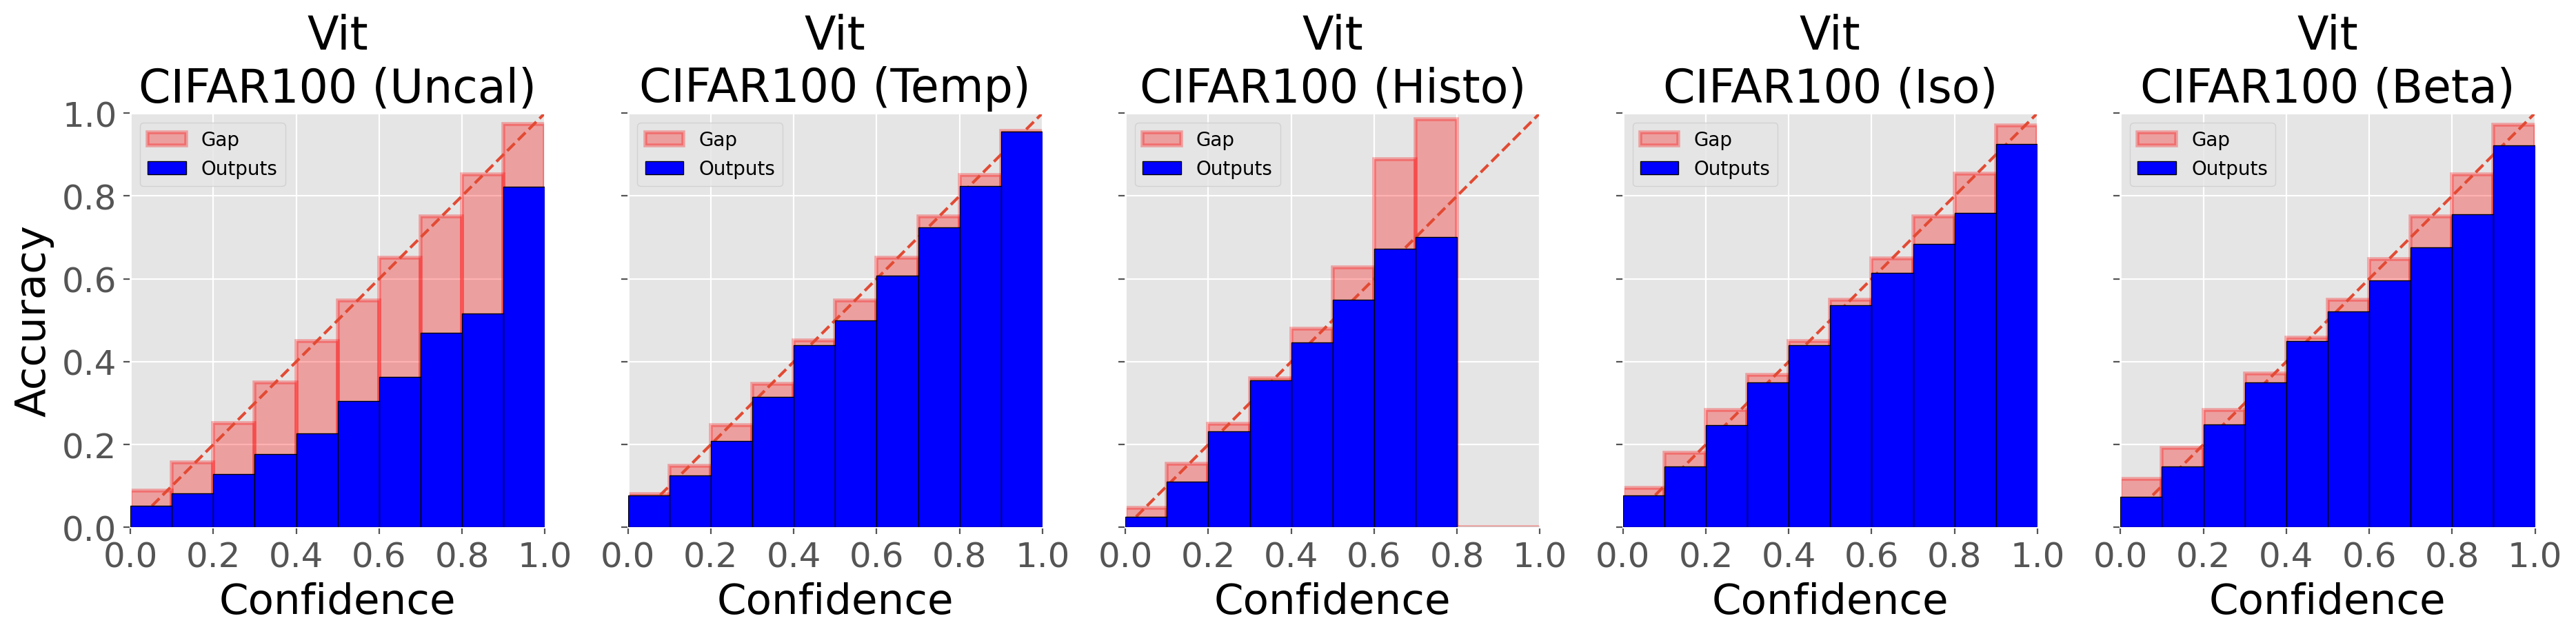

In [92]:
gen_plots(files[:2], plot_names = ["Vit CIFAR100", 
                               ], M = 10, val_set=False)